<a href="https://colab.research.google.com/github/alunfes/GoogleColabProjects/blob/main/ArbAnalysis3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
######################################################################
#板データを使い、同一銘柄の同一時点の価格差を調べて、どの程度収益機会があるのか、一定期間でどの程度の収益になるのかを分析する。
#データはUSDT, USDCをその時点のレートで調整する。
#
######################################################################
######################################################################
######################################################################
######################################################################

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
import numpy as np

In [3]:
directory = '/content/drive/My Drive/arb/BoardData'

In [19]:
######################################################
############ Read Data ##################
######################################################
def read_bybit():
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith('bybit')]
    bybit_df_list = {}
    for file in files:
        bybit_df_list[file.split('/')[-1].split('_')[1]] = pd.read_csv(file)
    return bybit_df_list

def read_apexpro():
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith('apexpro')]
    df_list = {}
    for file in files:
        df_list[file.split('/')[-1].split('_')[1]] = pd.read_csv(file)
    return df_list


bybit_df_list = read_bybit()
apex_df_list = read_apexpro()

In [20]:
######################################################
############ Pre-process Data ##################
######################################################
def convert_Unnamed_col_name(apex_df_list, bybit_df_list):
    for key in list(bybit_df_list.keys()):
        if 'Unnamed' in bybit_df_list[key].columns[0]:
            bybit_df_list[key].rename(columns={bybit_df_list[key].columns[0]: 'ts'}, inplace=True)
    for key in list(apex_df_list.keys()):
        if 'Unnamed' in apex_df_list[key].columns[0]:
            apex_df_list[key].rename(columns={apex_df_list[key].columns[0]: 'ts'}, inplace=True)
    return apex_df_list, bybit_df_list


def convert_apex_timestamp(apex_df_list):
    converted_list = {}
    for k in apex_df_list:
        converted_list[k] = apex_df_list[k]
        converted_list[k]['ts'] = (converted_list[k]['ts'] / 1000000).astype(int)
    return converted_list

def convert_bybit_timestamp(bybit_df_list):
    converted_list = {}
    for k in bybit_df_list:
        converted_list[k] = bybit_df_list[k]
        converted_list[k]['ts'] = (converted_list[k]['ts'] / 1000).astype(int)
    return converted_list

def merge_same_ts(apex_df_list, bybit_df_list):
    # For entries with the same timestamp, keep only the first entry
    for key in bybit_df_list:
        bybit_df_list[key] = bybit_df_list[key].drop_duplicates(subset='ts', keep='first').reset_index(drop=True)
    for key in apex_df_list:
        apex_df_list[key] = apex_df_list[key].drop_duplicates(subset='ts', keep='first').reset_index(drop=True)
    return apex_df_list, bybit_df_list

def interpret_ts(apex_df_list, bybit_df_list):
    def __func(df):
        # 最小値から最大値までのtsの範囲を生成
        ts_range = pd.DataFrame({'ts': range(df['ts'].min(), df['ts'].max() + 1)})
        # ts_rangeと元のdfをマージし、欠損データがNaNとして追加される
        merged_df = pd.merge(ts_range, df, on='ts', how='left')
        # 前方補間を使用して、NaN値を補完
        filled_df = merged_df.ffill()
        return filled_df
    adjusted_apex_df_list = apex_df_list.copy()
    adjusted_bybit_df_list = bybit_df_list.copy()
    for key in list(adjusted_apex_df_list.keys()):
        adjusted_apex_df_list[key] = __func(adjusted_apex_df_list[key])
    for key in list(adjusted_bybit_df_list.keys()):
        adjusted_bybit_df_list[key] = __func(adjusted_bybit_df_list[key])
    return adjusted_apex_df_list, adjusted_bybit_df_list



apex_df_list, bybit_df_list = convert_Unnamed_col_name(apex_df_list, bybit_df_list)
apex_df_list = convert_apex_timestamp(apex_df_list)
bybit_df_list = convert_bybit_timestamp(bybit_df_list)
apex_df_list, bybit_df_list = merge_same_ts(apex_df_list, bybit_df_list)
apex_df_list, bybit_df_list = interpret_ts(apex_df_list, bybit_df_list)

In [21]:
######################################################
############ Convert Apexpro USDC to USDT ##################
######################################################

def adjust_usdc_to_usdt(apex_df_list, usdc_usdt_df):
    adjusted_df = {}
    for key in list(apex_df_list.keys()):
        avax_df = apex_df_list[key].copy()
        usdt_df = usdc_usdt_df.copy()
        # usdt_dfとavax_dfをtsカラムを基準に結合
        merged_df = avax_df.merge(usdt_df, on='ts', suffixes=('', '_usdt'))
        # 変換計算
        for i in range(3):
            merged_df[f'bid{i}_price'] = merged_df[f'bid{i}_price'] / (0.5 * (merged_df['bid0_price_usdt'] + merged_df['ask0_price_usdt']))
            merged_df[f'ask{i}_price'] = merged_df[f'ask{i}_price'] / (0.5 * (merged_df['bid0_price_usdt'] + merged_df['ask0_price_usdt']))
        # 不要なカラムを削除
        remove_cols = []
        for col in list(merged_df.columns):
            if 'usdt' in col:
                remove_cols.append(col)
        merged_df = merged_df.drop(columns=remove_cols)
        # nanを含む行を削除
        adjusted_df[key.replace('USDC', 'USDT')] = merged_df.dropna()
    return adjusted_df


apex_df_list = adjust_usdc_to_usdt(apex_df_list, bybit_df_list['USDCUSDT'])


In [23]:
######################################################
############ Analyze Price Diff ##################
######################################################

'''
apexproのkeyでloop回す。
同じkeyのbybitを特定する。
共通範囲のtsのstart, endを特定する。
範囲内のtsの一致を確認する。
それぞれのdfのbid/askの乖離が大きい方の組み合わせでエントリーして乖離が0になるとした時のfee控除後の利益率を計算して記録する。

apex, bybitに加えて複数の取引所を対象に加えても対応できるコードにすべき
'''
def analyze_price_diff(apex_df_list, bybit_df_list, fee_ratio=0.005):
    results = {}
    for key in list(apex_df_list.keys()):
        if key in list(bybit_df_list.keys()):
            merged_df = apex_df_list[key].merge(bybit_df_list[key], on='ts', suffixes=('_apex', '_bybit'))
            merged_df = merged_df.dropna()
            result = []
            for index, entry in merged_df.iterrows():
                short_price = entry['bid0_price_apex'] if entry['bid0_price_apex'] > entry['ask0_price_bybit'] else entry['ask0_price_bybit']
                long_price = entry['ask0_price_apex'] if entry['ask0_price_apex'] < entry['bid0_price_bybit'] else entry['bid0_price_bybit']
                profit = (1 - fee_ratio) * (long_price - short_price)
                profit_rate = profit / short_price
                result.append({
                    'ts': entry['ts'],
                    'short_entry_price': short_price,
                    'long_entry_price': long_price,
                    'profit_rate': profit_rate
                })
            results[key] = result
        else:
            print(key, ' is not in bybit df list !')
    return results





results = analyze_price_diff(apex_df_list, bybit_df_list, fee_ratio=0.005)

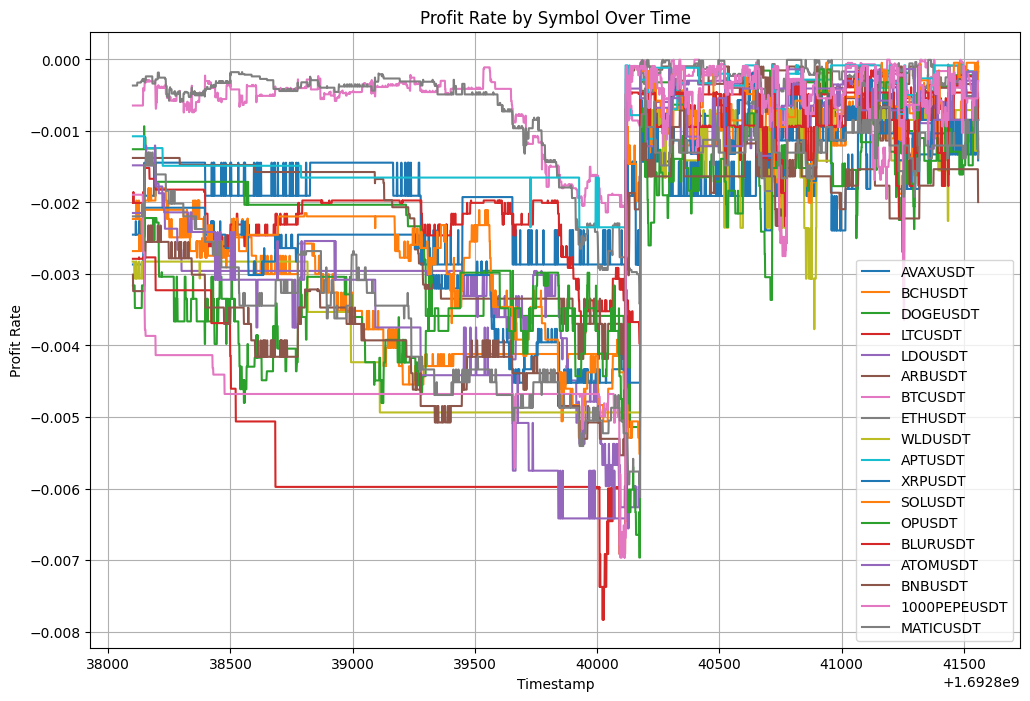

Symbol: AVAXUSDT
Mean Profit Rate: -0.001851339065808932
Max Profit Rate: -0.00048254122211452736
Median Profit Rate: -0.0019057219625881038
Standard Deviation: 0.0005999136687358295
---
Symbol: BCHUSDT
Mean Profit Rate: -0.0024786668058028372
Max Profit Rate: -0.00025810635538267866
Median Profit Rate: -0.002487518164341642
Standard Deviation: 0.001344868269517919
---
Symbol: DOGEUSDT
Mean Profit Rate: -0.0018073321295698154
Max Profit Rate: -0.00015612741252151488
Median Profit Rate: -0.001710958261685149
Standard Deviation: 0.001240856227160333
---
Symbol: LTCUSDT
Mean Profit Rate: -0.0016117899627937913
Max Profit Rate: -0.00015207091548227248
Median Profit Rate: -0.001972099405397311
Standard Deviation: 0.0009542301058974725
---
Symbol: LDOUSDT
Mean Profit Rate: -0.0022127021215841824
Max Profit Rate: -0.00029692629065947195
Median Profit Rate: -0.0029569093610699046
Standard Deviation: 0.00156824442596442
---
Symbol: ARBUSDT
Mean Profit Rate: -0.0015187441952810008
Max Profit Rat

In [27]:

def plot_profit_rates_by_symbol(results):
    plt.figure(figsize=(12, 8))
    for symbol, symbol_data in results.items():
        ts_values = [entry['ts'] for entry in symbol_data]
        profit_rates = [entry['profit_rate'] for entry in symbol_data]
        plt.plot(ts_values, profit_rates, label=symbol)
    plt.xlabel('Timestamp')
    plt.ylabel('Profit Rate')
    plt.title('Profit Rate by Symbol Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


def display_statistics_by_symbol(results):
    for symbol, symbol_data in results.items():
        profit_rates = [entry['profit_rate'] for entry in symbol_data]
        print(f"Symbol: {symbol}")
        print(f"Mean Profit Rate: {np.mean(profit_rates)}")
        print(f"Max Profit Rate: {np.max(profit_rates)}")
        print(f"Median Profit Rate: {np.median(profit_rates)}")
        print(f"Standard Deviation: {np.std(profit_rates)}")
        print("---")

# analyze_price_diff関数の呼び出し
results = analyze_price_diff(apex_df_list, bybit_df_list)

# 銘柄ごとにProfit Rateをグラフとして表示
plot_profit_rates_by_symbol(results)

# 銘柄ごとの乖離率の統計データを表示
display_statistics_by_symbol(results)

In [94]:
print('Apexpro-AVAXUSDT')
apex_df_list['AVAXUSDT']

Apexpro-AVAXUSDT


,ts,bid0_price,bid0_volume,ask0_price,ask0_volume,bid1_price,bid1_volume,ask1_price,ask1_volume,bid2_price,bid2_volume,ask2_price,ask2_volume
0,1692838101,10.305210,1820.0,10.310205,832.0,10.295220,4976.4,10.315201,655.2,10.290224,2137.2,10.320196,3988.4
1,1692838102,10.305210,1820.0,10.310205,832.0,10.295220,4976.4,10.315201,655.2,10.290224,2137.2,10.320196,3988.4
2,1692838103,10.305210,1820.0,10.310205,832.0,10.300215,2137.2,10.315201,655.2,10.295220,4976.4,10.320196,3988.4
3,1692838104,10.305210,1820.0,10.310205,832.0,10.300215,2137.2,10.315201,655.2,10.290224,2137.2,10.320196,3988.4
4,1692838105,10.305210,1820.0,10.310205,832.0,10.300215,2137.2,10.315201,655.2,10.290224,2137.2,10.320196,3988.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3453,1692841554,10.276265,655.2,10.281261,1664.0,10.271269,1430.0,10.286257,1539.2,10.266274,3380.0,10.291252,2652.0
3454,1692841555,10.276265,655.2,10.281261,4154.8,10.271269,1430.0,10.286257,1539.2,10.266274,3380.0,10.291252,2652.0
3455,1692841556,10.276265,655.2,10.281261,4154.8,10.271269,1430.0,10.286257,1539.2,10.266274,3380.0,10.291252,2652.0
3456,1692841557,10.276265,655.2,10.286257,1539.2,10.266274,3380.0,10.291252,2652.0,10.261278,1820.0,10.296248,561.6


In [95]:
print('Bybit-AVAXUSDT')
bybit_df_list['AVAXUSDT']

Bybit-AVAXUSDT


,ts,bid0_price,bid0_volume,ask0_price,ask0_volume,bid1_price,bid1_volume,ask1_price,ask1_volume,bid2_price,bid2_volume,ask2_price,ask2_volume
0,1692837894,10.33,6397.5,10.335,737.1,10.325,14287.2,10.340,3563.0,10.32,9734.7,10.345,10568.9
1,1692837895,10.33,6445.8,10.335,1026.3,10.325,14287.2,10.340,3563.0,10.32,9734.7,10.345,10568.9
2,1692837896,10.33,6445.8,10.335,1026.3,10.325,14135.4,10.340,3563.0,10.32,9734.7,10.345,10568.9
3,1692837897,10.33,6445.8,10.335,1026.3,10.325,14135.4,10.340,3563.0,10.32,9734.7,10.345,10568.9
4,1692837898,10.33,6445.8,10.335,1026.3,10.325,14135.4,10.340,3563.0,10.32,9734.7,10.345,10568.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,1692841750,10.28,3612.1,10.290,8071.7,10.275,12614.9,10.295,10377.2,10.27,11425.1,10.300,9601.1
3857,1692841751,10.28,3612.1,10.290,7699.3,10.275,12614.9,10.295,10377.2,10.27,11425.1,10.300,9601.1
3858,1692841752,10.28,3612.1,10.290,7699.3,10.275,13279.0,10.295,10377.2,10.27,11425.1,10.300,9601.1
3859,1692841753,10.28,3612.1,10.290,7699.3,10.275,13279.0,10.295,10377.2,10.27,11425.1,10.300,9601.1


In [98]:
def calculate_price_spread(df1, df2):
    # 必要なカラムを抽出して新しいDataFrameを作成
    df = pd.DataFrame({
        'ts': df1['ts'],
        'bid1_df1_price': df1['bid1_price'],
        'ask1_df2_price': df2['ask1_price'],
        'ask1_df1_price': df1['ask1_price'],
        'bid1_df2_price': df2['bid1_price']
    })
    # 乖離率を計算して新しいカラムとして追加
    df['spread_ratio_df1-bid_df2-ask'] = (df['ask1_df2_price'] - df['bid1_df1_price']) / (df['bid1_df1_price'] + df['ask1_df2_price'])
    df['spread_ratio_df1-ask_df2-bid'] = (df['ask1_df1_price'] - df['bid1_df2_price']) / (df['bid1_df2_price'] + df['ask1_df1_price'])
    return df.dropna()

res = calculate_price_spread(apex_df_list['AVAXUSDT'].copy(), bybit_df_list['AVAXUSDT'].copy())
res

,ts,bid1_df1_price,ask1_df2_price,ask1_df1_price,bid1_df2_price,spread_ratio_df1-bid_df2-ask,spread_ratio_df1-ask_df2-bid
0,1.692838e+09,10.295220,10.340,10.315201,10.325,0.002170,-0.000475
1,1.692838e+09,10.295220,10.340,10.315201,10.325,0.002170,-0.000475
2,1.692838e+09,10.300215,10.340,10.315201,10.325,0.001928,-0.000475
3,1.692838e+09,10.300215,10.340,10.315201,10.325,0.001928,-0.000475
4,1.692838e+09,10.300215,10.340,10.315201,10.325,0.001928,-0.000475
...,...,...,...,...,...,...,...
3856,NaN,NaN,10.295,NaN,10.275,NaN,NaN
3857,NaN,NaN,10.295,NaN,10.275,NaN,NaN
3858,NaN,NaN,10.295,NaN,10.275,NaN,NaN
3859,NaN,NaN,10.295,NaN,10.275,NaN,NaN


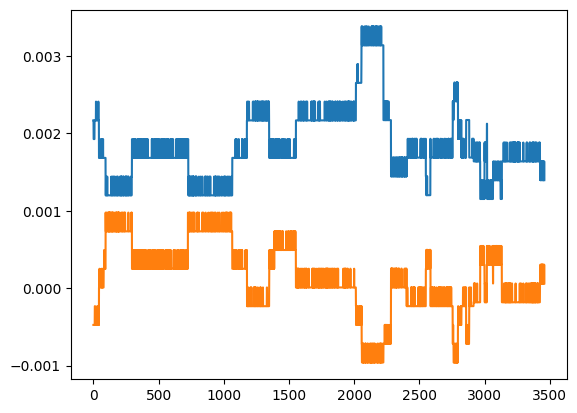

In [114]:
plt.plot(res['spread_ratio_df1-bid_df2-ask'])
plt.plot(res['spread_ratio_df1-ask_df2-bid'])

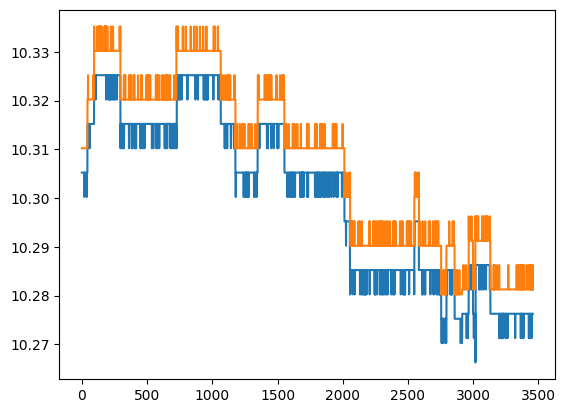

In [9]:
merged_df = apex_df_list['AVAXUSDT'].merge(bybit_df_list['AVAXUSDT'], on='ts', suffixes=('_apex', '_bybit'))
plt.plot(merged_df['bid0_price_apex'])
plt.plot(merged_df['ask0_price_apex'])

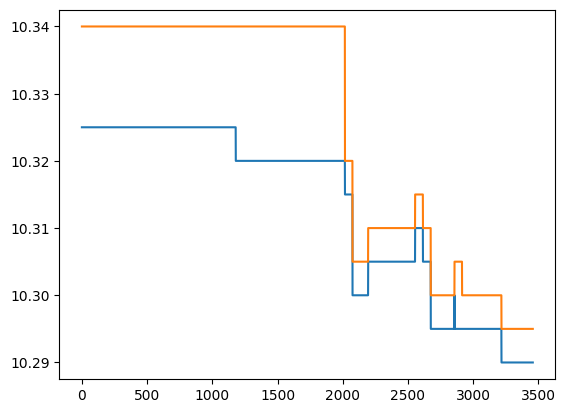

In [10]:
plt.plot(merged_df['bid0_price_bybit'])
plt.plot(merged_df['ask0_price_bybit'])

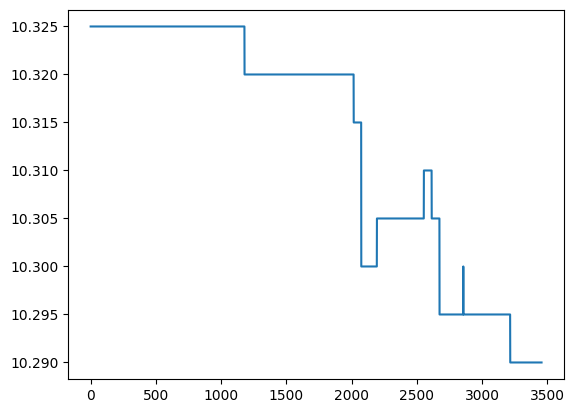

In [109]:
plt.plot(merged_df['bid0_price_bybit'])

In [ ]:
bid1=100.1
ask1=100.2
bid2=100.2
ask2=100.3

->
bid1=100.2
ask1=100.2
bid2=100.2
ask2-100.2

entry = long=ask1=100.2, short=
